# Examples/Testing of pyMBE 

Some examples and tests using a model based on the Maxwell-Bloch equations. Use the contents pane on the left to navigate.
Some may not be finished yet. 

* Absorption/dispersion
    * Narrow homogeneous feature
    * Spatially extendded, inhomogeneously broadened medium
    * Multi-$\pi$ pulse propagation
* Photon echo 
    * Usual 2-pulse echo, inhomogeneously broadened
    * Three-pulse echo
    * ROSE protocol
    * AFC
* Hole-burning
    * Narrow hole, optically thick medium
    * (ideally burning back too, but will need to extend the model for this)
* Sub-wavelength:
    * Reflection off sample edge
    * Reflection from resonant features
    * Cavity using atoms
* Cavity
    * Reflection/transmission on empty, resonant cavity
    * Reflection/transmission on empty, off-resonant cavity
    * Change of atom spectrum due to presence of cavity.
    * Hole-burning in a cavity.
    * Optimal $\pi$-pulse in an impedance matched cavity
* Active switching stuff
    * Gradient echo
    * Gradient echo with direction reversed
    * Cavity Q-switching

# Imports 

In [1]:
import sys
#sys.path.append('/home/morgan/Gropbox/mypy/pythonpackages')
#from MBE_2way import MBE_1D_SVEA
from spylind import MBE as mb
from pylab import *
import MT
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
from IPython.display import HTML, display
import os
from matplotlib import rc
#rc('animation', html='html5') #Set animations to display as embedded html5 videos
rc('animation', html='jshtml') #Set animations to display as embedded html5 videos

%matplotlib inline

#### Make a video for absoloutely no reason #####
from matplotlib import animation

def iterdim(a, axis=0):
    """Make an iterator out of a numpy array that iterates over an arbitrary dimension
    
    Returns an iterator.
    """
    a = numpy.asarray(a);
    leading_indices = (slice(None),)*axis
    for i in xrange(a.shape[axis]):
        yield a[leading_indices+(i,)]
        
def make_movie(arr, totalTime=10, tAx=None, titleStr='', frameRate=10, axis=0, xlab="", ylab="", fname=None, bColorbar=True, **kwargs):
    """Make an animated movie from a numpy array
    
    returns a matplotlib animation object.
    """
    N=arr.shape[axis]
    numFrames=totalTime*frameRate
    frameInds=linspace(0, N-1, numFrames).astype('i8')
    fig = figure()
    im = imshow(arr.take(0, axis=axis), interpolation="none", cmap="inferno", vmax=arr.max(), vmin=arr.min(), aspect='auto', **kwargs)
    titObj=title(titleStr)
    xlabel(xlab)
    ylabel(ylab)
    if bColorbar:
        colorbar()
    

    def update(frNum):
        #print("frmNum: {}".format(frNum))
        indx=frameInds[frNum]
        im.set_array(arr.take(indx, axis=axis))
        if tAx is not None:
            newTitle=titleStr.format(tAx[indx])
        titObj.set_text(newTitle)

    ani = animation.FuncAnimation(fig, func=update, frames=numFrames, 
                           repeat=False, interval=1/frameRate*1000)
    close(fig)
    if fname is not None:
        ani.save(fname)
        return
    return ani

def showMovie(fname):
    html=HTML("""
    <video width="640" height="480" src="{0}" type="video/mp4" controls>
    </video>
    """.format(fname))
    return html

def make_movie_cached(*args, **kwargs):
    if 'fname' not in kwargs:
        raise ValueError("Need to supply a 'fname' (the name of the video file to save)")
    fname = kwargs.pop("fname")
    
    if 'overwrite' in kwargs:
        bOverwrite = kwargs.pop('overwrite')
    else: 
        bOverwrite = False
    
    print(fname)
    if not os.path.isfile(fname) or bOverwrite:
        ani = make_movie(*args, **kwargs)
        ani.save(fname)
    showMovie(fname)
    


def lor(t, width, center=0): 
    return MT.lorentzian(t, [1.,width,center])
def gauss(t, width, center=0):
    return MT.gauss(t, [1., center, width])
def hyp_sec(t, width, center=0):
    return 1./cosh((t-center)/width)#*1.76)

def chirp(t, start_freq, stop_freq, tStart=None, tStop=None, phase=0, bComplex=False, bUpDown=False):
    if tStop is None:
        tStop=t[-1]
    if tStart is None:
        tStart=t[0]
    if bUpDown:
        tStop = (tStart + tStop)/2
        
    totTime = tStop-tStart

    Istart=  t.searchsorted(tStart)
    Iend= t.searchsorted(tStop)
    slc=slice(Istart,Iend)
    y= np.zeros(t.size, dtype='f8') 
    if bComplex:
        y = y.astype('c16')
    tRel = t[slc] - tStart #relevant bit
    span = stop_freq-start_freq
    chirpiness = span/totTime

    
    if bComplex:
        yRel = exp(tRel*2j*pi*(start_freq + chirpiness/2*tRel) + 1j*phase)

    else:
        yRel = cos(tRel*2*pi*(start_freq + chirpiness/2*tRel) + phase)
    y[slc] = yRel

    if bUpDown:
        y += chirp(t, stop_freq, start_freq, tStart=tStop, tStop =tStop+totTime, phase = tStop*2*pi*(start_freq + chirpiness/2*tStop) + phase, 
                   bComplex=bComplex, bUpDown=False)
    return y


No pretty printing stuff (probably because no Pandas)


In [2]:
# Automatically reload changed modules, useful when fiddling with the simulation code
%load_ext autoreload
%autoreload 2

# Absorption/Dispersion

## Narrow homogeneous feature

In [6]:
simObj=mb.MBE_1D_SVEA(detAx=array([0]), cavityParams={}, length_in_lambdas=10, pts_per_lambda=10)
p=simObj.params
t=linspace(0,1,500)
EinRv=1*MT.gauss(t, [1,0.45,0.15]) + 0j
EinFw=1*MT.gauss(t, [1,0.25,0.15]) + 0j
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialState(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 70.0
simObj.setAtomParams(lineShape=lineF, T1=0.01, Taux=None)#0.003);
simObj.setCavityParams(R1=0.,R2=0.0)
Pout=simObj.calculate(linspace(0,1.0,200))
mb.showInputsOutputs(simObj.res.fields)
mb.showMeanPol(simObj.res)

Doing cavity mode calcs


TypeError: setInitialState() got an unexpected keyword argument 'P0'

## Inhomogeneously Broadened Medium
Pulse in the forwards direction then in the backwards direction

........................................................................................................................................................................................................

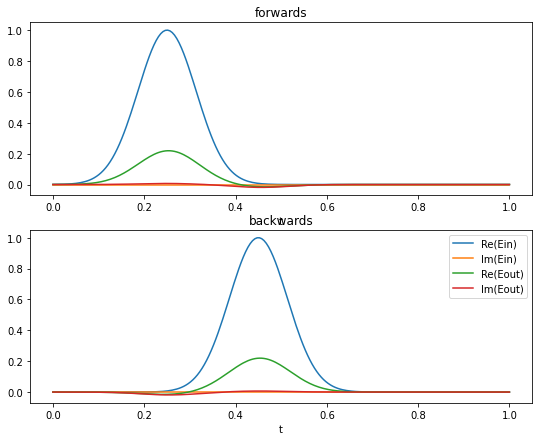

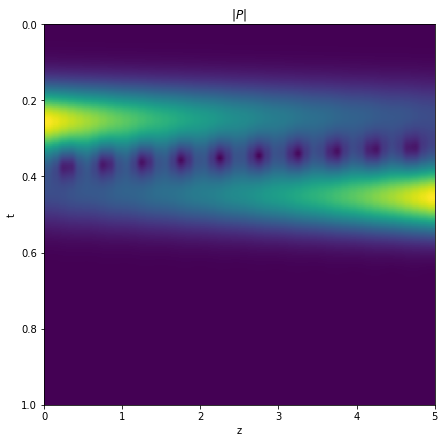

In [4]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-10,10,50), length_in_lambdas=5, pts_per_lambda=10)
p=simObj.params
t=linspace(0,1,500)
EinRv=1*MT.gauss(t, [1,0.45,0.15]) + 0j
EinFw=1*MT.gauss(t, [1,0.25,0.15]) + 0j
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 3.0
simObj.setAtomParams(lineShape=lineF, T1=100, Taux=None)#0.003);
Pout=simObj.calculate(linspace(0,1.0,200))
mb.showInputsOutputs(simObj.res.fields)
mb.showMeanPol(simObj.res)
r=simObj.res


### Excitation vs Frequency

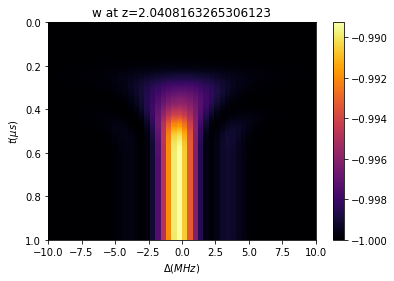

In [6]:
mb.show_w_delt_vs_t(r, z=2)

In [7]:
make_movie(r.w.real, tAx=r.t, axis=0, titleStr='t={:.2f}', fname="inh_1.mp4")
showMovie("inh_1.mp4")

## Large pulse propagation 

###  $\pi$

........................................................................................................................................................................................................

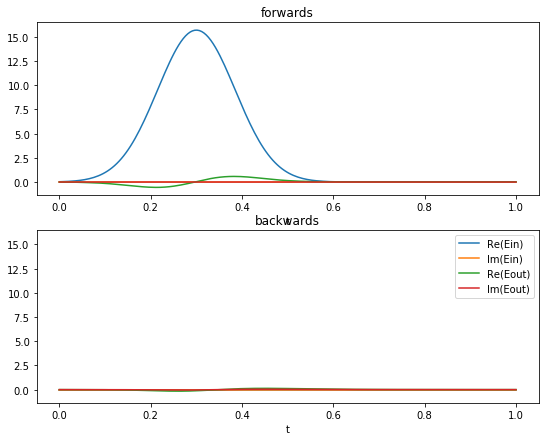

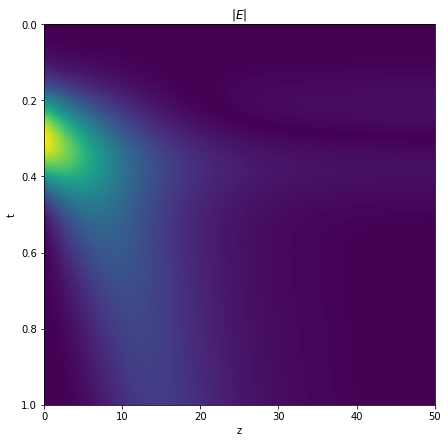

In [8]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-10,10,30), length_in_lambdas=50, pts_per_lambda=5)
p=simObj.params
t=linspace(0,5,1000)
piLength= 0.2
piHeight= pi/piLength
EinFw= piHeight*MT.gauss(t, [1,0.3,piLength])  
EinRv= 0*piHeight*MT.gauss(t, [1,1.5,piLength])  
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions()
lineF=lambda delt: 15.0
simObj.setAtomParams(lineShape=lineF, T1=100)#0.003);
t_prop=linspace(0,1,200)
Pout=simObj.calculate(t_prop)
r=simObj.res
mb.showInputsOutputs(simObj.res.fields)
mb.showFieldAbs(simObj.res)

### $2\pi$ Soliton

........................................................................................................................................................................................................

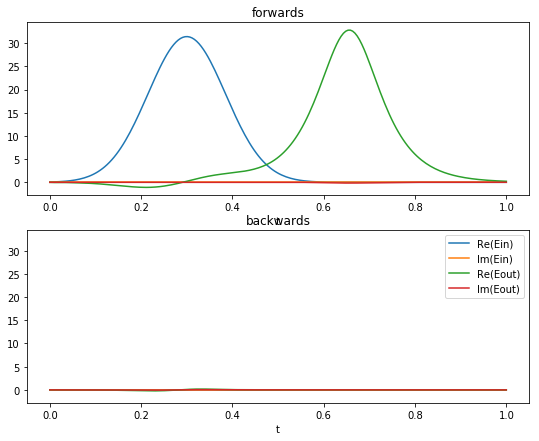

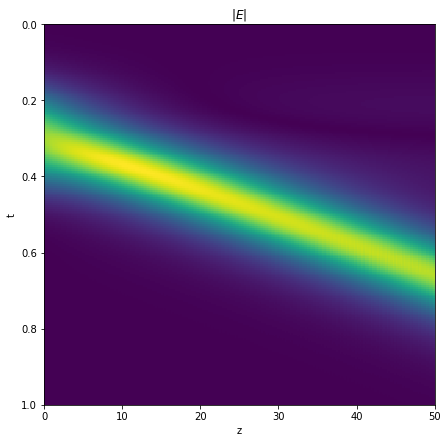

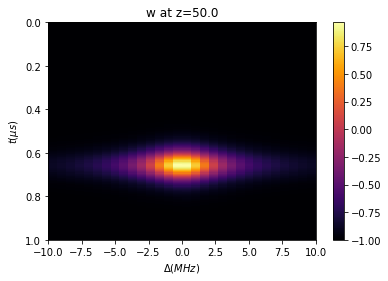

In [9]:
EinFw= 2*piHeight*MT.gauss(t, [1,0.3,piLength])  
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
Pout=simObj.calculate(t_prop)
mb.showInputsOutputs(simObj.res.fields)
mb.showFieldAbs(simObj.res)
mb.show_w_delt_vs_t(simObj.res)

### $4\pi$  pulse break-up

........................................................................................................................................................................................................

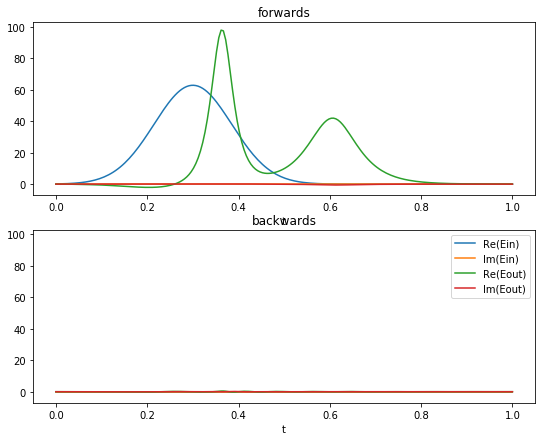

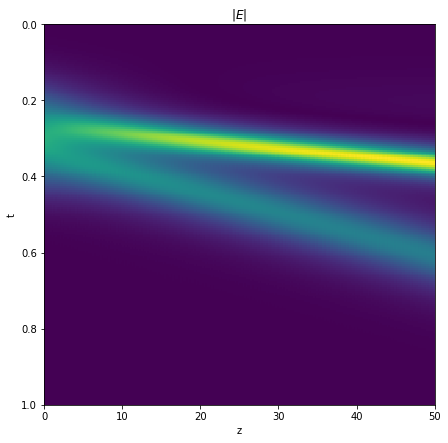

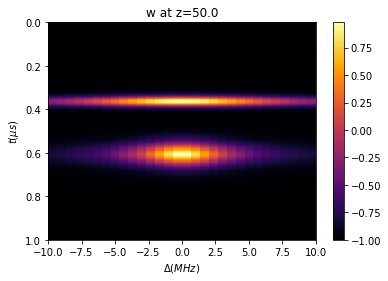

In [10]:
EinFw= 4*piHeight*MT.gauss(t, [1,0.3,piLength])  
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
Pout=simObj.calculate(t_prop)
r=simObj.res
mb.showInputsOutputs(simObj.res.fields)
mb.showFieldAbs(simObj.res)
mb.show_w_delt_vs_t(r)

In [4]:
showMovie('4pi.mp4')

In [11]:
# 4pi animation
make_movie(r.w.real, tAx=r.t, axis=0, 
                      titleStr='t={:.2f}', xlab="$\Delta$", ylab='z', 
                      extent=[r.det[0], r.det[-1], r.z[-1], r.z[0]],
                      fname="4pi.mp4")


# Optical rephasing

## Two-pulse photon echo


........................................................................................................................................................................................................

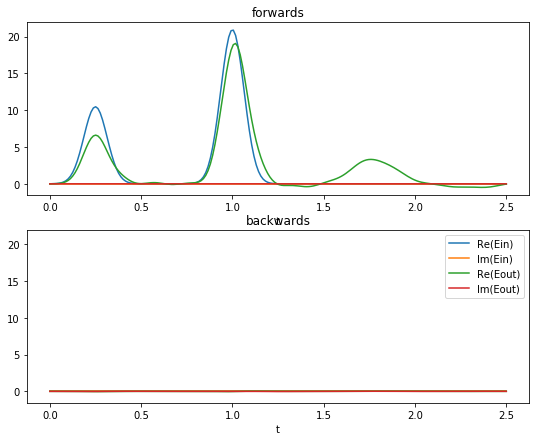

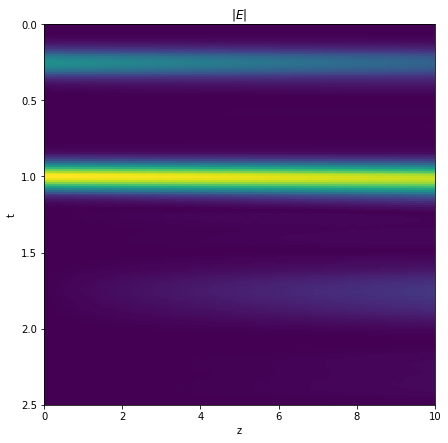

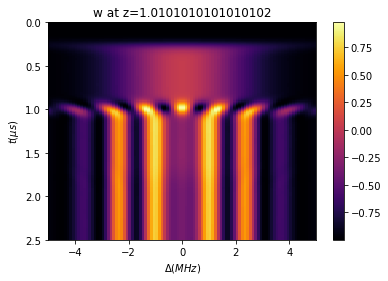

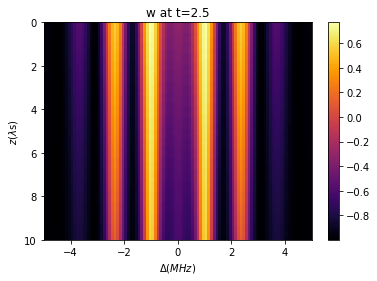

In [37]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-5,5,100), cavityParams={}, length_in_lambdas=10, pts_per_lambda=10)
p=simObj.params
t=linspace(0,2,500)
EinRv= zeros(t.size)
piLength= 0.15
piHeight= pi/piLength
prbLength= 0.15
EinFw= piHeight/2*MT.gauss(t, [1,0.25,prbLength]) + piHeight*MT.gauss(t, [1,1.0,piLength])  
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 1.0
simObj.setAtomParams(lineShape=lineF, T1=100, Taux=None)#0.003);
Pout=simObj.calculate(linspace(0,2.5,200))
r=simObj.res

mb.showInputsOutputs(simObj.res.fields)
mb.showFieldAbs(simObj.res)
mb.show_w_delt_vs_t(r, z=1)
mb.show_w_delt_vs_z(r)

##  ROSE
"Revival of Silenced Echo"

........................................................................................................................................................................................................

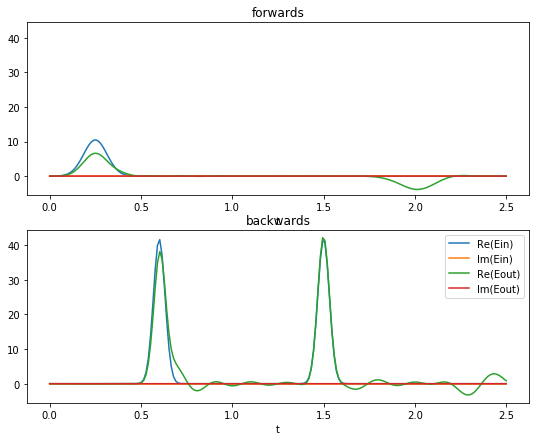

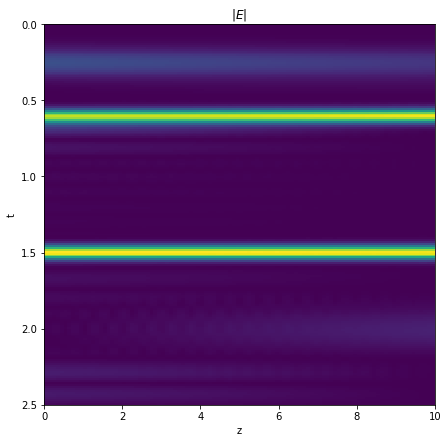

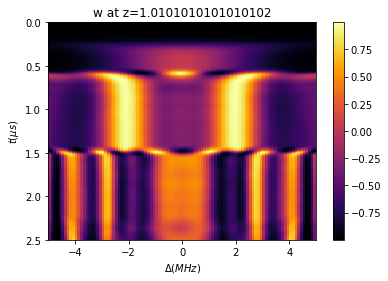

In [12]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-5,5,100), length_in_lambdas=10, pts_per_lambda=10)
p=simObj.params
t=linspace(0,2,500)
piLength= 0.075
piHeight= pi/piLength
prbLength= 0.15
EinFw= pi/prbLength/2*gauss(t, prbLength,0.25) 
EinRv=piHeight*( gauss(t, piLength, 0.6) + gauss(t, piLength, center=1.5) )
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions()
lineF=lambda delt: 1.0
simObj.setAtomParams(lineShape=lineF, T1=100 )#0.003);
Pout=simObj.calculate(linspace(0,2.5,200))
r=simObj.res

mb.showInputsOutputs(simObj.res.fields)
mb.showFieldAbs(simObj.res)
mb.show_w_delt_vs_t(r, z=1)

In [13]:
make_movie(r.w.real, tAx=r.t, axis=0, titleStr='t={:.2f}', xlab="$\Delta$", ylab='z', 
                      extent=[r.det[0], r.det[-1], r.z[-1], r.z[0]],
                     fname="ROSE.mp4")


In [14]:
showMovie("ROSE.mp4")

## AFC
Including both forwards and backwards propagating pulses, simply to show they're independent

........................................................................................................................................................................................................

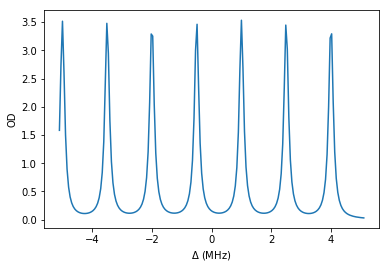

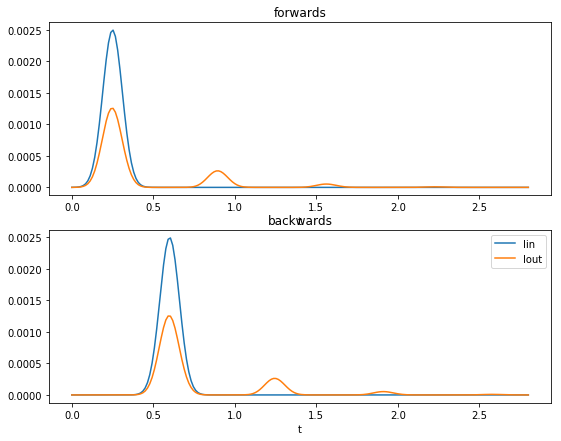

In [40]:

detAx=linspace(-5.1,5.1,200)
simObj=mb.MBE_1D_SVEA(detAx=detAx, length_in_lambdas=10,  pts_per_lambda=5)
p=simObj.params
t=linspace(0,2,500)
EinFw= 0.05*MT.gauss(t, [1,0.25,0.2]) 
EinRv= 0.05*MT.gauss(t, [1,0.6,0.2]) 
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions()
lineF= 3.5*sum([lor(detAx, width=0.18, center=pos) for pos in arange(-5.0,5.0,1.5)], axis=0)
simObj.setAtomParams(lineShape=lineF, T1=100, Taux=None)
Pout=simObj.calculate(linspace(0,2.8,200))
r=simObj.res
figure()
plot(detAx,lineF)
xlabel('$\Delta$ (MHz)')
ylabel('OD')
mb.showInputsOutputsI(simObj.res.fields)

# Hole-burning

## Power broadening

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Text(0, 0.5, 'Hole depth')

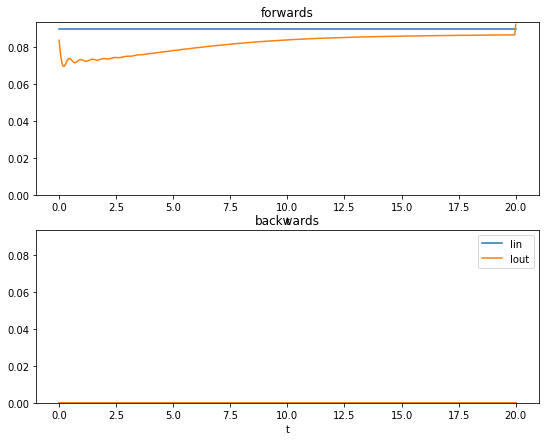

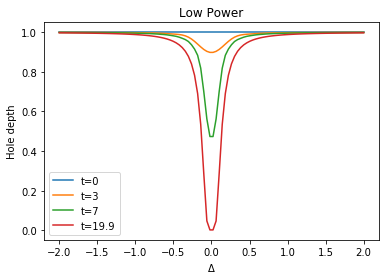

In [21]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-2,2,100), length_in_lambdas=1, pts_per_lambda=10)
p=simObj.params
t=linspace(0,20,1000)
EinRv=zeros(t.size)
EinFw=0.3*ones(t.size)

simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 0.2
simObj.setAtomParams(lineShape=lineF, T1=None, Taux=2.0)
Pout=simObj.calculate(linspace(0,20.0,500))
r=simObj.res
#Display
mb.showInputsOutputsI(simObj.res.fields)
figure()
mnPop=r.pop.mean(axis=1)
for T in [0,3,7,19.9]:
    plot(r.det, mnPop[r.t.searchsorted(T)], label='t={}'.format(T))
legend()
title('Low Power')
xlabel("$\Delta$")
ylabel('Hole depth')

In [ ]:
EinFw=2*ones(t.size)
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
lineF=lambda delt: 0.2
simObj.setAtomParams(lineShape=lineF, T1=None, Taux=2.0)
Pout=simObj.calculate(linspace(0,20.0,500))
r=simObj.res
#Display
mb.showInputsOutputsI(simObj.res.fields)
figure()
mnPop=r.pop.mean(axis=1)
for T in [0,3,7,19.9]:
    plot(r.det, mnPop[r.t.searchsorted(T)], label='t={}'.format(T))
legend()
title('High Power')
xlabel("$\Delta$")
ylabel('Hole depth')

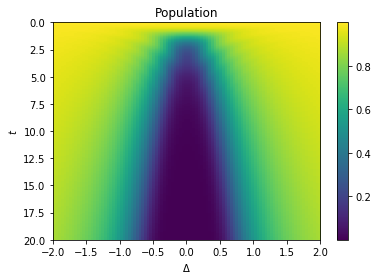

In [17]:
# Image
imshow(mnPop, aspect='auto', extent=[r.det[0], r.det[-1], r.t[-1], r.t[0]])
title('Population')
xlabel('$\Delta$')
ylabel('$t$')
colorbar()

## Burning a trench

max freq: 99.95
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Text(0, 0.5, 'Hole depth')

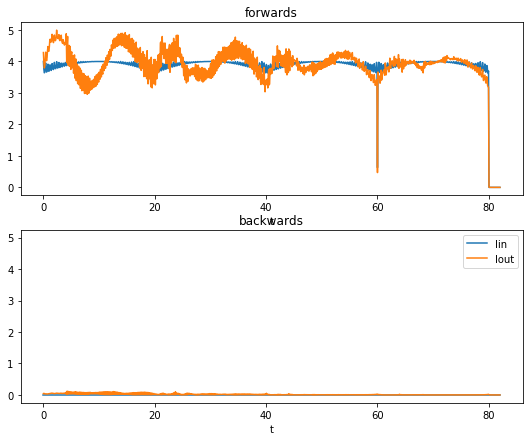

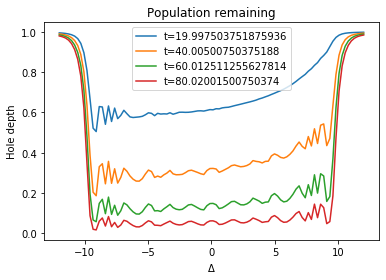

In [93]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-12,12,100), length_in_lambdas=1, pts_per_lambda=2)

p=simObj.params
tSwp=linspace(0,20,2000)
print("max freq:", 1/(tSwp[1]-tSwp[0]) )

sweep = 2*chirp(tSwp, -10,10, bComplex=True, bUpDown=False)
Nsweeps = 4
EinFw = hstack(Nsweeps*[sweep]) #Repeated sweep
t = arange(EinFw.size)*(tSwp[1]-tSwp[0])
EinRv=0*EinFw

simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 0.1
simObj.setAtomParams(lineShape=lineF, T1=10, Taux=10.0)
Pout=simObj.calculate(linspace(0,t[-1]+2,1000))
r=simObj.res
#Display
mb.showInputsOutputsI(simObj.res.fields)
figure()
mnPop=r.pop.mean(axis=1)
for T in (arange(4)+1)/4.*t.max()-0.01:
    plot(r.det, mnPop[r.t.searchsorted(T)], label='t={}'.format(T))
legend()
title('Population remaining')
xlabel("$\Delta$")
ylabel('Hole depth')

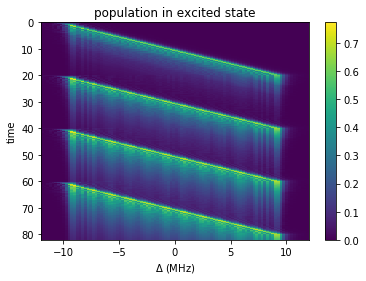

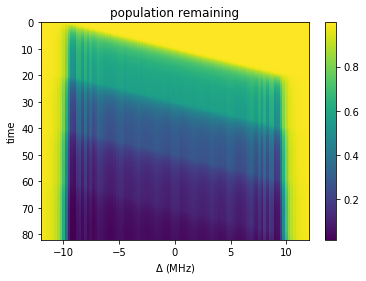

In [94]:
mnExc=r.w.mean(axis=1)
imshow((mnExc+1)/2, aspect='auto',  extent=[r.det[0], r.det[-1], r.t[-1], r.t[0]])
title('population in excited state')
xlabel(r'$\Delta$ (MHz)')
ylabel('time')
colorbar()

figure()
imshow(mnPop, aspect='auto', extent=[r.det[0], r.det[-1], r.t[-1], r.t[0]])
title('population remaining')
xlabel(r'$\Delta$ (MHz)')
ylabel('time')
colorbar()



## Optically and spatially thick medium

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Text(0,0.5,'Hole depth')

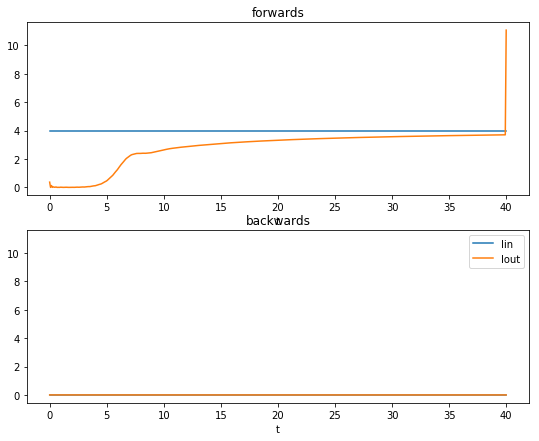

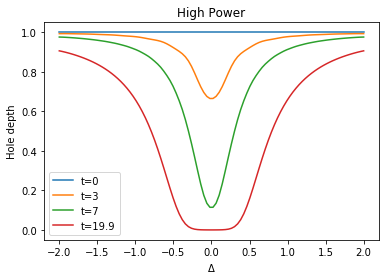

In [18]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-2,2,100), length_in_lambdas=20, pts_per_lambda=10)
p=simObj.params
t=linspace(0,40,1000)
EinRv=zeros(t.size)
EinFw=2*ones(t.size)

simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 10.0
simObj.setAtomParams(lineShape=lineF, T1=None, Taux=2.0)
Pout=simObj.calculate(linspace(0,40.0,500))
r=simObj.res
#Display
mb.showInputsOutputsI(simObj.res.fields)
figure()
mnPop=r.pop.mean(axis=1)
for T in [0,3,7,19.9]:
    plot(r.det, mnPop[r.t.searchsorted(T)], label='t={}'.format(T))
legend()
title('High Power')
xlabel("$\Delta$")
ylabel('Hole depth')

In [19]:
# Hole-depth
make_movie(r.pop, tAx=r.t, axis=0, titleStr='t={:.2f}', xlab="$\Delta$", ylab='z', 
           extent=[r.det[0], r.det[-1], r.z[-1], r.z[0]],
          fname='hole_depth.mp4')


In [20]:
showMovie('hole_depth.mp4')

In [21]:
# Excitation because it looks cool
make_movie(r.w, tAx=r.t, axis=0, titleStr='t={:.2f}', xlab="$\Delta$", ylab='z', 
           extent=[r.det[0], r.det[-1], r.z[-1], r.z[0]],
          fname='hole_depth_exc.mp4')


In [22]:
showMovie('hole_depth_exc.mp4')

## 3-Pulse Photon Echo

........................................................................................................................................................................................................

Text(0.5,1,'Depth-averaged hole-depth at the end')

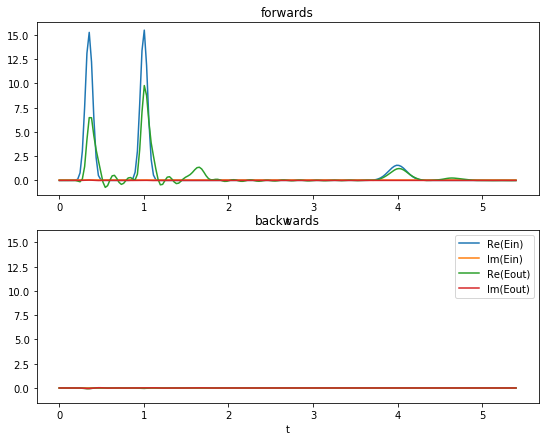

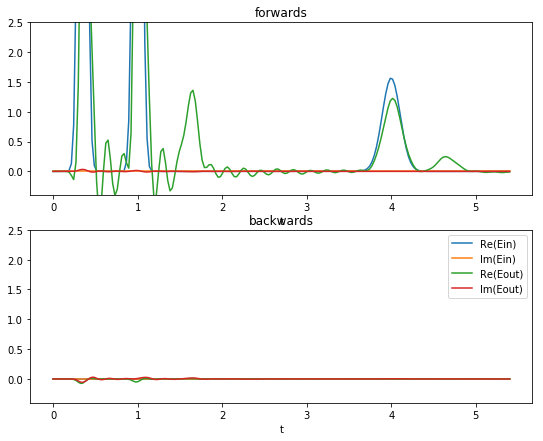

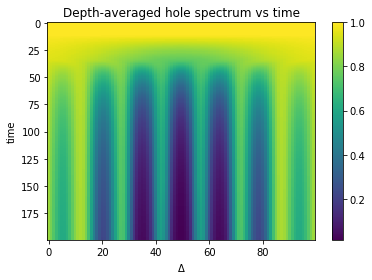

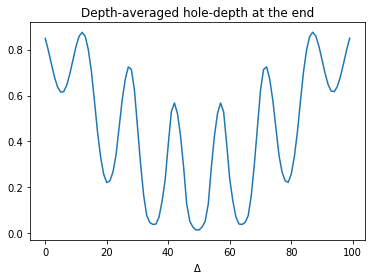

In [47]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-5,5,100), cavityParams={}, length_in_lambdas=10,  pts_per_lambda=10)
p=simObj.params
t=linspace(0,10,500)
EinRv=zeros(t.size)
EinFw=10*pi/2*( gauss(t, 0.1, 0.35)  + gauss(t, 0.1, 1.0)) + 2*pi/4*gauss(t, 0.25, 4.0)
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 2.0
simObj.setAtomParams(lineShape=lineF, T1=None, Taux=1)#0.003);
Pout=simObj.calculate(linspace(0,5.4,200))
r=simObj.res
mb.showInputsOutputs(r.fields)
mb.showInputsOutputs(r.fields, ylm=[-0.4,2.5])

figure()
imshow(r.pop[:].mean(axis=1), aspect='auto')
colorbar()
xlabel('$\Delta$')
ylabel('time')
title('Depth-averaged hole spectrum vs time')
figure()
plot(r.pop[-1].mean(axis=0))
xlabel('$\Delta$')
title('Depth-averaged hole-depth at the end')
#mb.showFieldAbs(r)
#mb.show_w_delt_vs_t(r)
#figure()


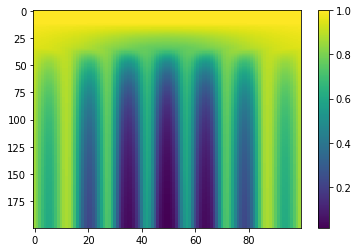

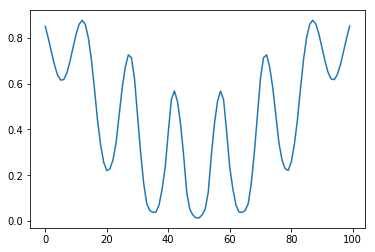

In [48]:
imshow(r.pop[:].mean(axis=1), aspect='auto')
colorbar()
figure()
plot(r.pop[-1].mean(axis=0))

# Cavity

## Emtpy cavity, $R_1= R_2=0.9$
### On-resonance

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.99999999999999956

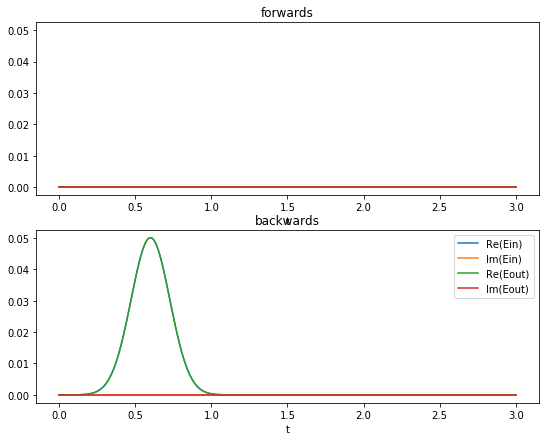

In [49]:
simObj=mb.MBE_1D_SVEA(detAx=0, length_in_lambdas=10.0, pts_per_lambda=5)
p=simObj.params
t=linspace(0,3,1000)
EinRv=0.05*gauss(t, 0.3, 0.6)
EinFw=0.00*gauss(t, 0.3, 0.2)
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 0.0
simObj.setAtomParams(lineShape=lineF, T1=50)
simObj.setCavityParams(R1=.9,R2=0.9)
Pout=simObj.calculate(linspace(0,3.0,500))
r=simObj.res
mb.showInputsOutputs(r.fields)

sum(abs(r.fields.EoutFw)**2 + abs(r.fields.EoutRv)**2)/sum(abs(r.fields.EinpRv)**2)

### Off-resonant

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1.0

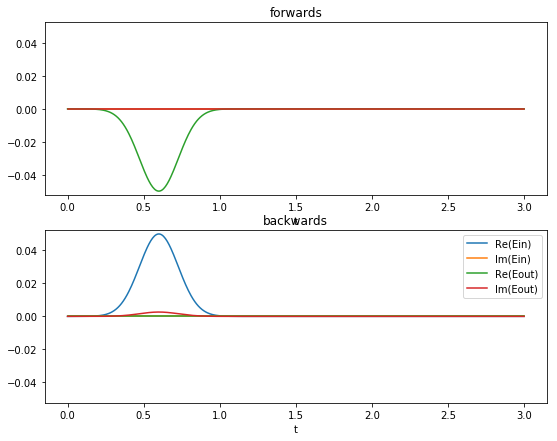

In [50]:
# Off-resonant
simObj=mb.MBE_1D_SVEA(detAx=0, length_in_lambdas=10.25, pts_per_lambda=5)
p=simObj.params
t=linspace(0,3,1000)
EinRv=0.05*gauss(t, 0.3, 0.6)
EinFw=0.00*gauss(t, 0.3, 0.2)
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 0.0
simObj.setAtomParams(lineShape=lineF, T1=50)
simObj.setCavityParams(R1=.9,R2=0.9)
Pout=simObj.calculate(linspace(0,3.0,500))
r=simObj.res
mb.showInputsOutputs(r.fields)

sum(abs(r.fields.EoutFw)**2 + abs(r.fields.EoutRv)**2)/sum(abs(r.fields.EinpRv)**2)

## Double-pass due to single mirror

............................................................................................................................................................................................................................................................................................................

0.65934840132841599

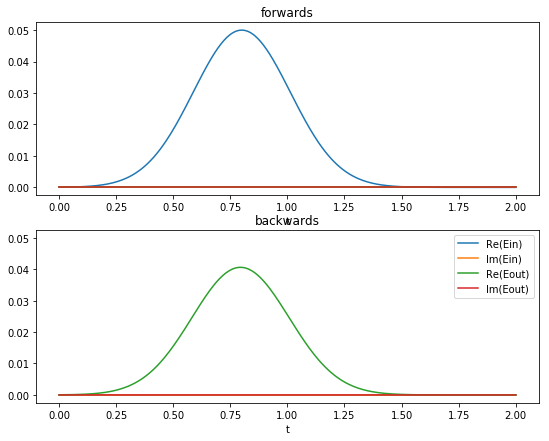

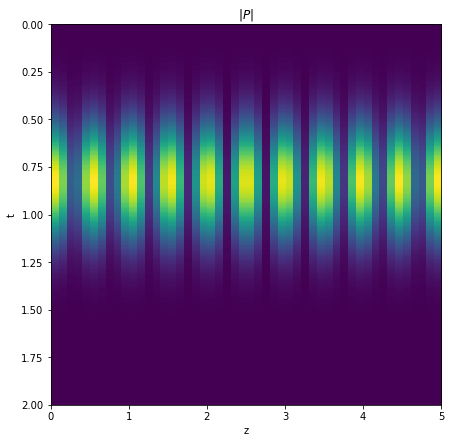

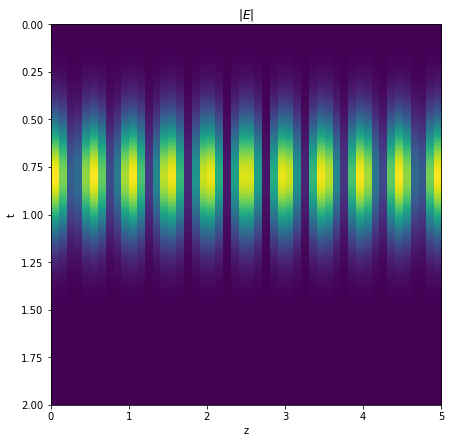

In [51]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-3,3,30), length_in_lambdas=5., pts_per_lambda=10)
p=simObj.params
t=linspace(0,3,1000)
EinRv=zeros(t.size)
EinFw=0.05*gauss(t, 0.5, 0.8)
#EinFw=where(t<0.8, EinFw, 0)
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 0.2
simObj.setAtomParams(lineShape=lineF, T1=50)
simObj.setCavityParams(R1=0.0,R2=1.0)
Pout=simObj.calculate(linspace(0,2.0,300))
r=simObj.res
mb.showInputsOutputs(simObj.res.fields)
mb.showMeanPol(simObj.res)
mb.showFieldAbs(simObj.res)

#Total output/input
sum(abs(r.fields.EoutFw)**2 + abs(r.fields.EoutRv)**2)/sum(abs(r.fields.EinpRv)**2 + abs(r.fields.EinpFw)**2)

## Impedance matching
### Check matching

............................................................................................................................................................................................................................................................................................................

0.0012315569007458665

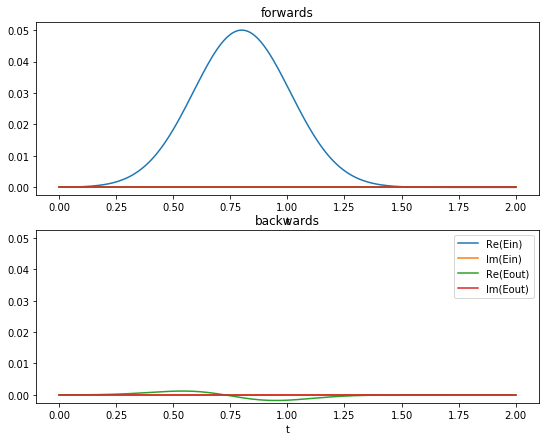

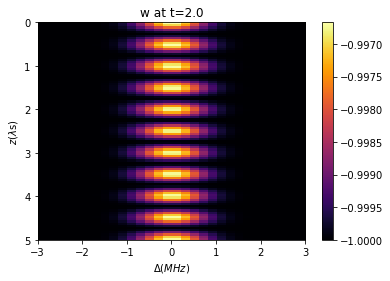

In [19]:
simObj=mb.MBE_1D_SVEA(detAx=linspace(-3,3,30), length_in_lambdas=5., pts_per_lambda=20)
p=simObj.params
t=linspace(0,3,1000)
EinRv=zeros(t.size)
EinFw=0.05*gauss(t, 0.5, 0.8)
#EinFw=where(t<0.8, EinFw, 0)
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: 0.2
simObj.setAtomParams(lineShape=lineF, T1=50)
simObj.setCavityParams(R1=0.67,R2=1.0) #Set R1 to the round-trip absorption from above 
Pout=simObj.calculate(linspace(0,2.0,300))
r=simObj.res
mb.showInputsOutputs(simObj.res.fields)
mb.show_w_delt_vs_z(simObj.res)
#mb.showFieldAbs(simObj.res)
#Total output/input
sum(abs(r.fields.EoutFw)**2 + abs(r.fields.EoutRv)**2)/sum(abs(r.fields.EinpRv)**2 + abs(r.fields.EinpFw)**2)


### $\pi$-pulse with biggest echo
 


In [103]:
EinRv=zeros(t.size)
fieldL=[]
for amp in linspace(1.3*pi, 8.0*pi, 30)[:]:
    EinFw=amp/8*gauss(t, 0.25,0.25) + amp*gauss(t, 0.125, 1.35) 
    simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
    Pout=simObj.calculate(linspace(0,2.8,200))
    r=simObj.res
    fieldL.append(r.fields)



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

(0, 5)

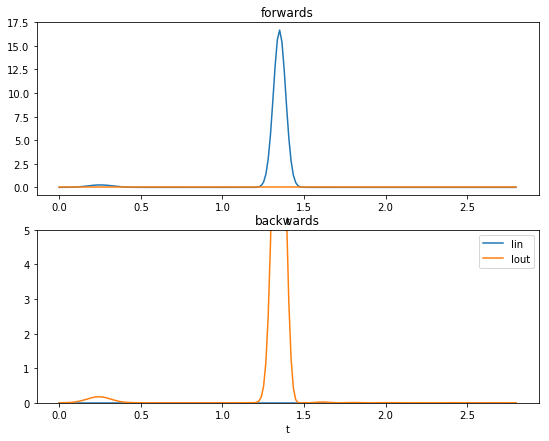

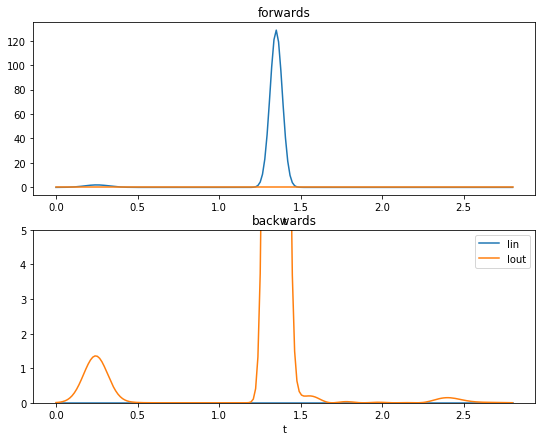

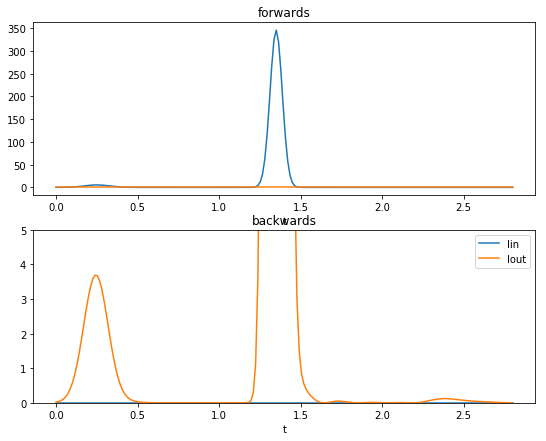

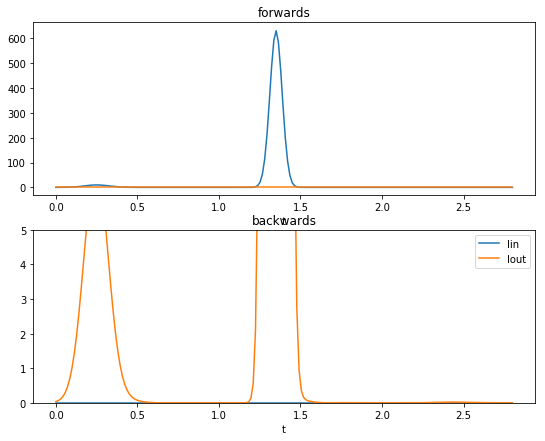

In [104]:
mb.showInputsOutputsI(fieldL[0])
ylim([0,5])
mb.showInputsOutputsI(fieldL[10])
ylim([0,5])
mb.showInputsOutputsI(fieldL[20])
ylim([0,5])
mb.showInputsOutputsI(fieldL[-1])
ylim([0,5])

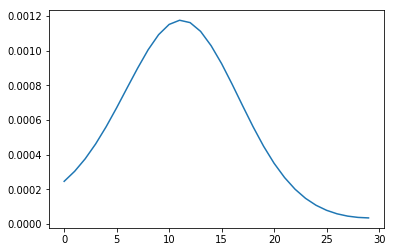

In [106]:
slc=slice(*r.t.searchsorted([2.2,2.5]))
#slc=slice(0,50)
echHeightL=[max(abs(f.EoutRv[slc])**2)/max(abs(f.EinpFw)**2) for f in fieldL]
plot(echHeightL)

..........................................................................................................................................................................................................................................................

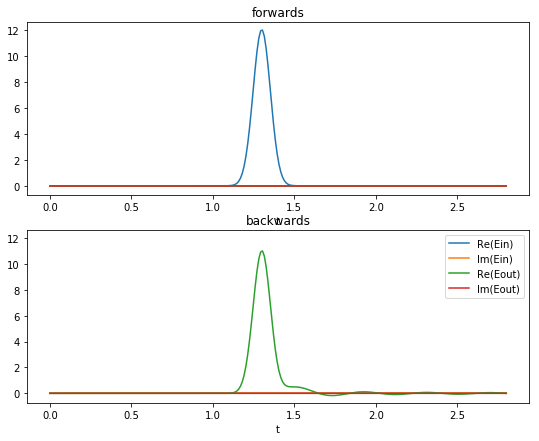

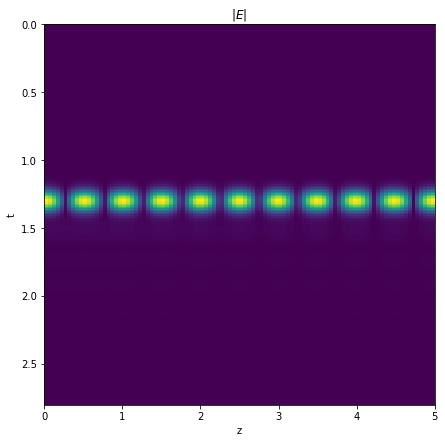

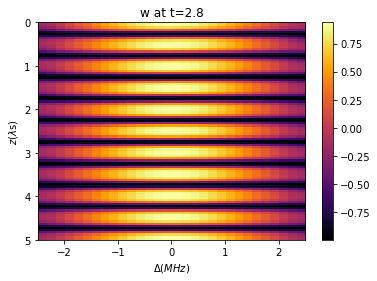

In [108]:
amp=linspace(1.3*pi, 8.0*pi, 30)[11]
EinFw=0*amp/4*gauss(t, 0.25,0.3) + amp*gauss(t, 0.125, 1.3) 
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
Pout=simObj.calculate(linspace(0,2.8,250))
r=simObj.res
mb.showInputsOutputs(r.fields)
mb.showFieldAbs(r)
mb.show_w_delt_vs_z(r)


Text(0,0.5,'w')

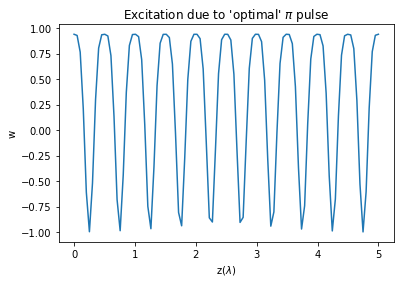

In [119]:
title("Excitation due to 'optimal' $\pi$ pulse")
plot(r.z,r.w[-1, :,int(r.w.shape[2]/2)])
xlabel('z($\lambda$)')
ylabel('w')


In [123]:
16/1.4*0.5


5.714285714285714

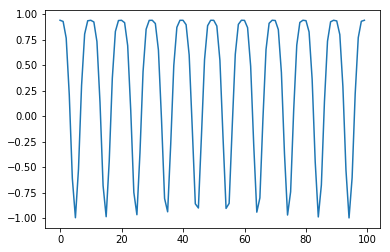

In [111]:
plot(r.w[-1, :,15])
#xlim([400,500])

(400, 475)

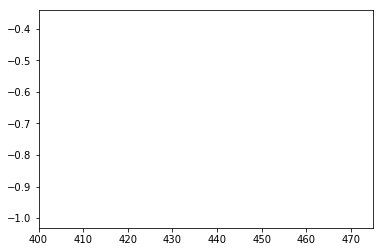

In [32]:
plot(r.w[-1, :,25])
xlim([400,475])

#  Scratch

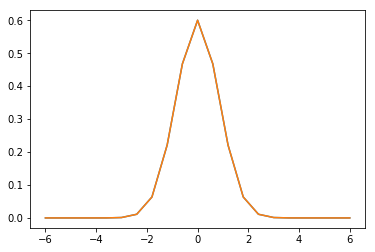

In [33]:
#def normaliseAbsorp(det, od):
def normAbsorp(det, od):
    det2=hstack([ [2*det[0]-det[1]], det, [2*det[-1] -det[-2]] ])
    dif=diff(det2)
    dfSm=interp(arange(0.5, dif.size-0.5, 1), arange(dif.size), dif)
    return od*dfSm

det=linspace(-6,6,21)
od=ones(det.size)
od=MT.gauss(det, [1,0,2])
odNew=normAbsorp(det,od)
plot(det,od*(det[4]-det[3]))
plot(det,odNew)

........................................................................................................................................................................................................

0.36214049571207058

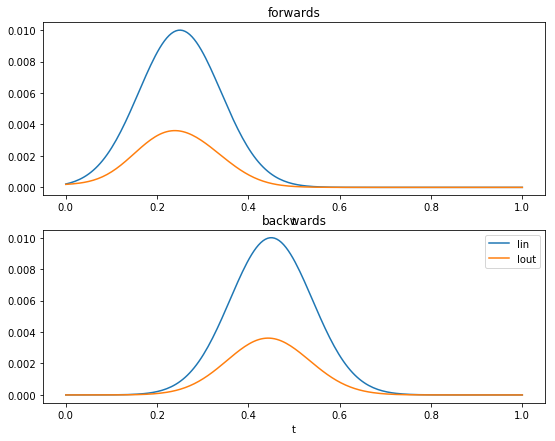

In [34]:
detAx=linspace(-5,5,25)
simObj=mb.MBE_1D_SVEA(detAx=detAx, cavityParams={}, length_in_lambdas=10, pts_per_lambda=10)

p=simObj.params
t=linspace(0,1,500)
EinRv=0.1*MT.gauss(t, [1,0.45,0.3]) + 0j
EinFw=0.1*MT.gauss(t, [1,0.25,0.3]) + 0j
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions()
lineF=lambda delt: 1
#line= normAbsorp(detAx,lineF(detAx))*detAx.size
line=lineF(detAx)
simObj.setAtomParams(lineShape=line, T1=100, Taux=None, bSmoothSpect=True)#0.003);
simObj.setCavityParams(R1=0.,R2=0.0)
Pout=simObj.calculate(linspace(0,1.0,200))
mb.showInputsOutputsI(simObj.res.fields)
f=simObj.res.fields
sum((abs(f.EoutRv)**2)/sum(abs(f.EinpRv)**2))

In [35]:
1/e

0.36787944117144233

In [36]:
MT.downsample?

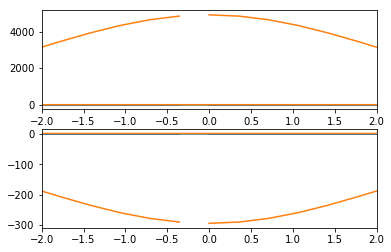

In [37]:

def showAbsorptionSpectrum(r, xlm=[-2,2], ylm=[None,None]):
    fax=fftfreq(r.t.size, r.t[1]-r.t[0])
    yout=fft(r.fields.EoutFw)
    yin=fft(r.fields.EinpFw)
    figure()
    subplot(211)
    plot(fax, abs(yout)**2)
    plot(fax, abs(yin)**2)
    xlim(xlm)
    subplot(212)
    plot(fax, abs(yout/yin)**2 )
    plot(fax, 1-0.06*abs(yin)**2)

    xlim(xlm)
    ylim(ylm)
showAbsorptionSpectrum(r)

In [38]:
import pandas as pd
pd.options.display.float_format = '${:,.3f}$'.format
pd.DataFrame(simObj.excArrs.M)

,0,1,2,3
0,(1-2.44929359829e-15j),0j,(1+0j),0j
1,0j,(1-2.44929359829e-15j),0j,(1+0j)
2,(1+0j),0j,0j,0j
3,0j,(1+0j),0j,0j


In [335]:
del res1

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

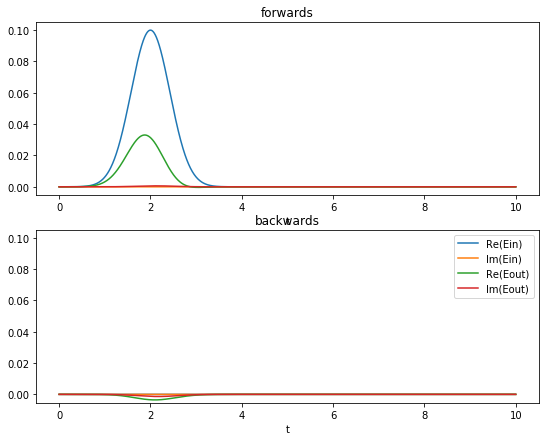

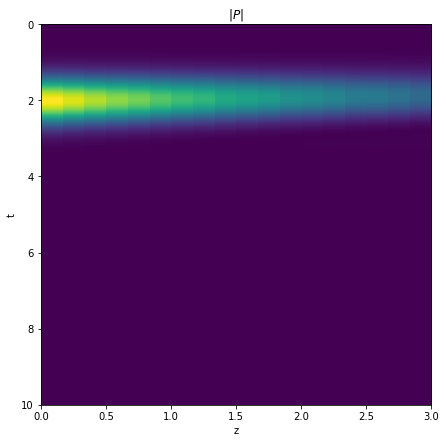

In [386]:
detAx=linspace(-3.5,3.5,300)
simObj=mb.MBE_1D_SVEA(detAx=detAx, cavityParams={}, length_in_lambdas=3, pts_per_lambda=6)
p=simObj.params
t=linspace(0,10,2000)
OD=2.5
EinFw=0.1*MT.gauss(t, [1,2.,1]) + 0j
EinRv=0*MT.gauss(t, [1,2.,1]) + 0j
simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=0, w0=-1, pop0=1)
lineF=lambda delt: OD*MT.lorentzian(delt,[1,2,0])
simObj.setAtomParams(lineShape=lineF, T1=5, Taux=None)#0.003);
simObj.setCavityParams(R1=0.,R2=0.0)
Pout=simObj.calculate(linspace(0,10.0,2000))
mb.showInputsOutputs(simObj.res.fields)
mb.showMeanPol(simObj.res)
from copy import copy, deepcopy
res1 = deepcopy(simObj.res)

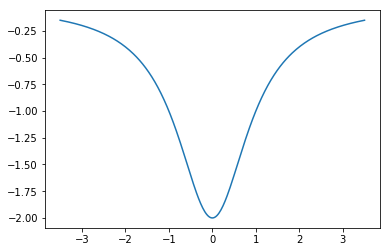

In [363]:
plot(detAx,lineF(detAx))

In [364]:
 MT.lorentzian(detAx, [1,0.1,cf])

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.005,
       0.005, 0.005, 0.006, 0.006, 0.007, 0.007, 0.008, 0.008, 0.009,
       0.01 , 0.011,

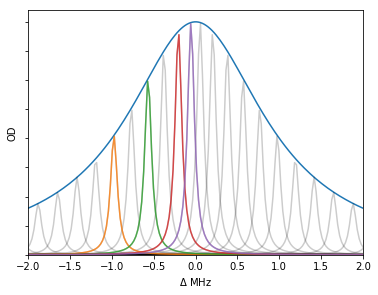

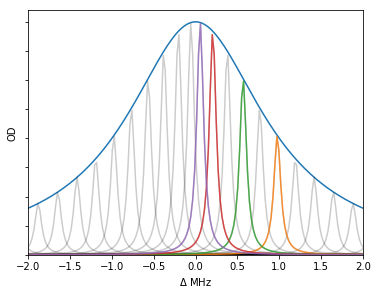

In [370]:
figure(figsize=(6,4.5))
endF = 3.0
N=100
halfDetAx = (arange(N)+1)/N*endF * linspace(1,0.5,N)
detAx2= hstack([ -halfDetAx[::-1], halfDetAx  ])
detAx2=detAx
plot(detAx2,-lineF(detAx2))
savefig("inhomogeneous_absorption_FD_1.pdf")
ax = gca()
ax.set_yticklabels([])
ax.set_ylim([0,2.1])
ax.set_xlim([-2,2])

centerFreqs=[-1.0,-0.6,-0.3,-0.2]
allPeaks = abs(linspace(-sqrt(3.5),sqrt(3.5),22))**1.2
allPeaks[:int(allPeaks.size/2)]*=-1
for cf in allPeaks:
    plot(detAx2, -MT.lorentzian(detAx2, [1,0.1,cf])*lineF(cf),'k-', alpha=0.2)

centerFreqs = allPeaks[allPeaks.searchsorted(centerFreqs)]
for cf in centerFreqs:
    #cf = allPeaksI[]
    plot(detAx2, -MT.lorentzian(detAx2, [1,0.1,cf])*lineF(cf), alpha=0.8)
xlabel('$\Delta$ MHz')
ylabel("OD")

savefig("inhomogeneous_absorption_FD_2.pdf")

if 1: 
    figure(figsize=(6,4.5))
    plot(detAx2,-lineF(detAx2))
    ax = gca()
    ax.set_yticklabels([])
    ax.set_ylim([0,2.1])
    ax.set_xlim([-2,2])

    centerFreqs=[-1.0,-0.6,-0.3,-0.2]
    allPeaks = abs(linspace(-sqrt(3.5),sqrt(3.5),22))**1.2
    allPeaks[:int(allPeaks.size/2)]*=-1
    for cf in allPeaks:
        plot(-detAx2, -MT.lorentzian(detAx2, [1,0.1,cf])*lineF(cf),'k-', alpha=0.2)

    centerFreqs = allPeaks[allPeaks.searchsorted(centerFreqs)]
    for cf in centerFreqs:
        #cf = allPeaksI[]
        plot(-detAx2, -MT.lorentzian(detAx2, [1,0.1,cf])*lineF(cf), alpha=0.8)
    xlabel('$\Delta$ MHz')
    ylabel("OD")

    savefig("inhomogeneous_absorption_FD_2_rev.pdf")


In [362]:
centerFreqs

array([-0.976, -0.567, -0.205, -0.055])

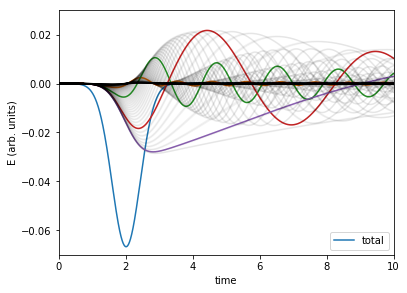

In [396]:
indsCol = detAx.searchsorted(centerFreqs)
inds = slice(50,250)
#for 
Pout=res1.P
fig=figure(figsize=(6,4.5))
ax=gca()
ax2=ax#twinx(ax)
ax.plot(t, -Pout[:,0,:].real.sum(axis=-1)/29)
ax.set_xlabel('time')
ax.set_ylabel('E (arb. units)')
ax.set_title('')
#ax2.set_ylabel(r"$10 \times$ E$_{rad}$")
ax2.set_ylim([-0.07,0.03])
ax.set_ylim(ax2.get_ylim())
ax.set_xlim([0,10])
legend(["total"], loc='lower right')
fig.savefig("inhomogeneous_absorption_TD.pdf")
_=ax2.plot(t,-Pout[:,0,indsCol].real/3)

ax2.plot(t,-Pout[:,0,inds].real/3,'k', alpha=0.05)
fig.savefig("inhomogeneous_absorption__all_TD.pdf")





Results(t=array([ 0.   ,  0.005,  0.01 , ...,  9.99 ,  9.995, 10.   ]), z=array([0.   , 0.182, 0.364, 0.545, 0.727, 0.909, 1.091, 1.273, 1.455,
       1.636, 1.818, 2.   ]), det=array([-3.5  , -3.477, -3.453, -3.43 , -3.406, -3.383, -3.36 , -3.336,
       -3.313, -3.289, -3.266, -3.242, -3.219, -3.196, -3.172, -3.149,
       -3.125, -3.102, -3.079, -3.055, -3.032, -3.008, -2.985, -2.962,
       -2.938, -2.915, -2.891, -2.868, -2.844, -2.821, -2.798, -2.774,
       -2.751, -2.727, -2.704, -2.681, -2.657, -2.634, -2.61 , -2.587,
       -2.564, -2.54 , -2.517, -2.493, -2.47 , -2.446, -2.423, -2.4  ,
       -2.376, -2.353, -2.329, -2.306, -2.283, -2.259, -2.236, -2.212,
       -2.189, -2.166, -2.142, -2.119, -2.095, -2.072, -2.048, -2.025,
       -2.002, -1.978, -1.955, -1.931, -1.908, -1.885, -1.861, -1.838,
       -1.814, -1.791, -1.768, -1.744, -1.721, -1.697, -1.674, -1.651,
       -1.627, -1.604, -1.58 , -1.557, -1.533, -1.51 , -1.487, -1.463,
       -1.44 , -1.416, -1.393, -1.37 , -1

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

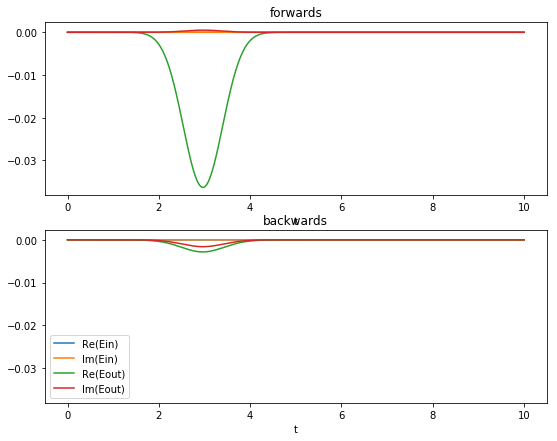

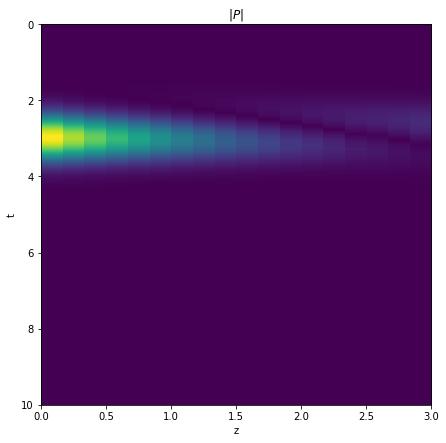

In [408]:
detAx=linspace(-3.5,3.5,300)
simObj=mb.MBE_1D_SVEA(detAx=-detAx, cavityParams={}, length_in_lambdas=3, pts_per_lambda=6)
p=simObj.params
t=linspace(0,10,2000)
EinFw=0.0*MT.gauss(t, [1,2.,1]) + 0j
EinRv=0*MT.gauss(t, [1,2.,1]) + 0j
lineF=lambda delt: -OD/1.*MT.lorentzian(delt,[1,2,0])

simObj.setInputs(EinFw=EinFw, EinRv=EinRv, tAx=t)
simObj.setInitialConditions(P0=res1.P[1000].copy(), w0=res1.w[1000].copy(), pop0=res1.pop[1000].copy())
simObj.setAtomParams(lineShape=lineF, T1=5, Taux=None)#0.003);
simObj.setCavityParams(R1=0.,R2=0.0)
Pout=simObj.calculate(linspace(0,10.0,2000))
mb.showInputsOutputs(simObj.res.fields)
mb.showMeanPol(simObj.res)
res2 = copy(simObj.res)

In [253]:
simObj.excArrs.fwMode

array([ 1.   +0.j   ,  0.415+0.91j , -0.655+0.756j, -0.959-0.282j,
       -0.142-0.99j ,  0.841-0.541j,  0.841+0.541j, -0.142+0.99j ,
       -0.959+0.282j, -0.655-0.756j,  0.415-0.91j ,  1.   -0.j   ])

In [322]:
import gc
gc.collect()

21371

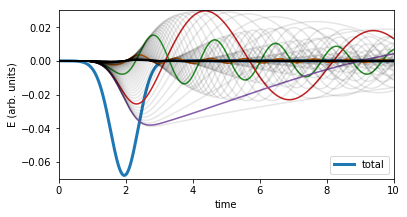

In [434]:
indsCol = detAx.searchsorted(centerFreqs)
inds = slice(50,250)
#for 
Pout=res1.P
Pout = (Pout*simObj.excArrs.fwMode.conj()[newaxis,:, newaxis]).sum(axis=1)/8

fig=figure(figsize=(6,3.1))
ax=gca()
ax2=ax#twinx(ax)
ax.plot(t, -Pout[:].real.sum(axis=-1)/40, lw=3)
ax.set_xlabel('time')
ax.set_ylabel('E (arb. units)')
ax.set_title('')
#ax2.set_ylabel(r"$10 \times$ E$_{rad}$")
ax2.set_ylim([-0.07,0.03])
ax.set_ylim(ax2.get_ylim())
ax.set_xlim([0,10])
legend(["total"], loc='lower right')
_=ax2.plot(t,-Pout[:,indsCol].real/3)
fig.savefig("inhomogeneous_absorption_TD.pdf")

ax2.plot(t,-Pout[:,inds].real/3,'k', alpha=0.05)
fig.savefig("inhomogeneous_absorption__all_TD.pdf")

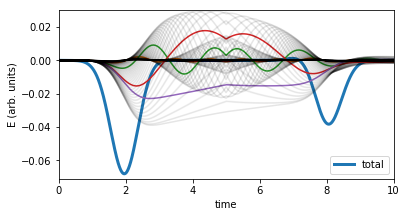

In [435]:
P = res1.P.copy()
P[P.shape[0]//2:] = res2.P[:P.shape[0]//2]
P = (P*simObj.excArrs.fwMode.conj()[newaxis,:, newaxis]).sum(axis=1)/8
#P = P[:,0]*1.05
indsCol = detAx.searchsorted(centerFreqs)
inds = slice(50,250)
#for 
zI = 6
fig=figure(figsize=(6,3.1))
ax=gca()
ax2=ax#twinx(ax)
ax.plot(t, -P[:,:].real.sum(axis=-1)/40, lw=3)
ax.set_xlabel('time')
ax.set_ylabel('E (arb. units)')
ax.set_title('')
#ax2.set_ylabel(r"$10 \times$ E$_{rad}$")
ax2.set_ylim([-0.071,0.03])
ax.set_ylim(ax2.get_ylim())
ax.set_xlim([0,10])
legend(["total"], loc='lower right')
fig.savefig("inhomogeneous_absorption_TD_ech.pdf")
_=ax2.plot(t,-P[:,indsCol].real/5)

ax2.plot(t,-P[:,inds].real/3,'k', alpha=0.05)
fig.savefig("inhomogeneous_absorption__all_TD_ech.pdf")





In [419]:
P.shape

(2000, 300)

In [424]:
zeros( (Ninsert, P.shape[1]), dtype='f8').shape

(399, 300)

In [425]:
P[int(N//2):].shape

(1000, 300)

In [432]:
Pnew = vstack( [P[:int(N//2)], zeros( (Ninsert, P.shape[1]), dtype='f8'), P[int(N//2):] ] )
Pnew.shape

(2399, 300)

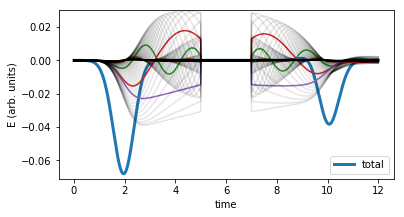

In [433]:
P = res1.P.copy()
N= P.shape[0]
P[N//2:] = res2.P[:N//2]
P = (P*simObj.excArrs.fwMode.conj()[newaxis,:, newaxis]).sum(axis=1)/8
Ninsert = int(2//(t[1]-t[0]))
Pnew = vstack( [P[:int(N//2)], zeros( (Ninsert, P.shape[1]), dtype='f8'), P[int(N//2):] ] )
tnew = arange(Pnew.shape[0]) * (t[1]-t[0])
#P = P[:,0]*1.05
indsCol = detAx.searchsorted(centerFreqs)
inds = slice(50,250)
#for 
zI = 6
fig=figure(figsize=(6,3.1))
ax=gca()
ax2=ax#twinx(ax)
ax.plot(tnew, -Pnew[:,:].real.sum(axis=-1)/40, lw=3)
ax.set_xlabel('time')
ax.set_ylabel('E (arb. units)')
ax.set_title('')
#ax2.set_ylabel(r"$10 \times$ E$_{rad}$")
ax2.set_ylim([-0.071,0.03])
ax.set_ylim(ax2.get_ylim())
legend(["total"], loc='lower right')

_=ax2.plot(tnew,-Pnew[:,indsCol].real/5)

ax2.plot(tnew,-Pnew[:,inds].real/3,'k', alpha=0.05)
fig.savefig("inhomogeneous_absorption__all_shelve.pdf")





/home/morgan/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


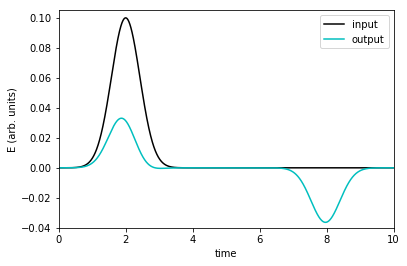

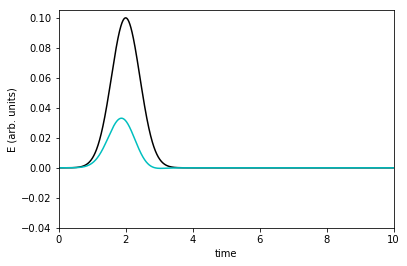

In [412]:
figure(figsize=(6,4))
flds = copy(res1.fields)
Einp = flds.EinpFw
Eout = flds.EoutFw.copy()
t=flds.t
Eout[Eout.shape[0]//2:] = res2.fields.EoutFw[:Eout.shape[0]//2]
#P = (P*simObj.excArrs.fwMode.conj()[newaxis,:, newaxis]).sum(axis=1)/32
plot(t,Einp,'k')
plot(t,Eout, 'c')
xlabel('time')
ylabel("E (arb. units)")
ylim([-0.04,0.105])
xlim([0,10])
legend(['input', 'output'])

savefig("echo_inp_output.pdf")
figure(figsize=(6,4))
plot(t,Einp,'k')
plot(t,res1.fields.EoutFw,'c')
xlabel('time')
ylabel("E (arb. units)")
ylim([-0.04,0.105])
xlim([0,10])
savefig("noecho_inp_output.pdf")


In [295]:
res1.fields.E

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])